In [13]:
import torch.nn as nn
import torchvision.models as models
import torch

In [14]:
new_model = models.inception_v3(pretrained=True, aux_logits=False)
new_model.fc



Linear(in_features=2048, out_features=1000, bias=True)

In [15]:
class encoderCNN(nn.Module):
    def __init__(self, embed_size, should_train=False):
        super(encoderCNN, self).__init__()
        self.should_train = should_train
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.dropout= nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        features = self.inception(x)
        
        for name, param in self.inception.named_parameters():
            param.requires_grad = False
        
#         for name, param in self.inception.named_parameters():
#             if "fc.weight" in name or "fc.bias" in name:
#                 param.requires_grad = True
#             else:
#                 param.required_grad = self.should_train
        
        
        return self.dropout(self.relu(features))
        

In [16]:
class decoderRNN(nn.Module):
    def __init__(self, embed_size,vocab_size, hidden_size, num_layers):
        super(decoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, caption):
        embeddings = self.dropout(self.embedding(caption))
        embeddings = torch.cat((features.unsqueeze(0),embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

In [17]:
class CNN2RNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers):
        super(CNN2RNN, self).__init__()
        self.encoderCNN = encoderCNN(embed_size)
        self.decoderRNN = decoderRNN(embed_size, vocab_size, hidden_size, num_layers)
    
    def forward(self, images, caption):
        x = self.encoderCNN(images)
        x = self.decoderRNN(x, caption)
        return x
    
    def captionImage(self, image, vocabulary, maxlength=50):
        result_caption = []
        
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None
            
            for _ in range(maxlength):
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                print(predicted.shape)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embedding(output).unsqueeze(0)
                
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
        return [vocabulary.itos[i] for i in result_caption]


In [18]:
import os
import pandas
import spacy

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from torchvision.transforms import transforms


In [19]:
spacy_eng = spacy.load("en")


In [20]:
class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
    
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]

In [21]:
annotation = pandas.read_csv("/content/captions.txt")
annotation.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [22]:
annotation['caption'].tolist()[:2]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .']

In [23]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir="/content/drive/MyDrive/VR_Image_captioning_project/Flicker8k_Dataset", caption_path="../input/flickr8kimagescaptions/flickr8k/captions.txt", freq_threshold=5, transform=None, data_length=10000):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pandas.read_csv(caption_path)[:data_length]
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold)
        
        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        
        numericalized_caption += self.vocab.numericalize(caption)
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [24]:
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)
        
        return img, targets


In [25]:
# transform = transforms.Compose(
#         [transforms.Resize((224, 224)), transforms.ToTensor(),]
#     )

transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )


In [26]:
def get_loader(root_dir="/content/drive/MyDrive/VR_Image_captioning_project/Flicker8k_Dataset", caption_path="/content/captions.txt", transform=transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    
    loader = DataLoader(dataset=dataset, batch_size=32, num_workers=8, shuffle=True, pin_memory=True, collate_fn=MyCollate(pad_value))
    
    return loader, dataset


In [27]:
loader, dataset = get_loader()


10000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Lets load a random example.

In [28]:
import random
import math

x, y = dataset[math.floor(random.random() * len(dataset))]
x.shape, y.shape

(torch.Size([3, 299, 299]), torch.Size([12]))

In [29]:
x[1]

tensor([[-0.6000, -0.6000, -0.5922,  ..., -0.4902, -0.4824, -0.4902],
        [-0.6000, -0.5922, -0.5843,  ..., -0.5059, -0.5059, -0.5137],
        [-0.5765, -0.5765, -0.5765,  ..., -0.4980, -0.5059, -0.5137],
        ...,
        [ 0.0196,  0.0196,  0.0275,  ..., -0.0667, -0.0431, -0.0353],
        [ 0.0196,  0.0275,  0.0431,  ..., -0.0039, -0.0196, -0.0196],
        [-0.0196, -0.0275, -0.0431,  ..., -0.0039,  0.0196,  0.0275]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([     1, 108890, 108621, 108927, 105487, 108272, 100204, 108929, 108926,
        108688, 108925,      2])
<SOS>
<SOS> the little boy rides his bicycle in a race . <EOS> 

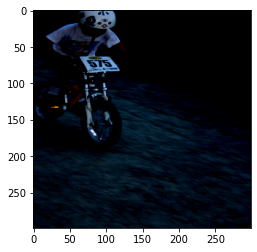

In [30]:
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(y)

print(dataset.vocab.itos[1])

for i in y:
    print(dataset.vocab.itos[int(i)],end=" ")

In [31]:
def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    print("saving checkpoint!")
    torch.save(state, filename)

In [32]:
def load_checkpoint(checkpoint, model, optimizer):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    model.load_state_optimizer(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step


In [33]:
#Training the model

In [34]:
from tqdm import tqdm
# from torchvision.utils.tensorboard import SummaryWriter

In [35]:
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
load_model = False
save_model=False
train_CNN = False



In [36]:
# Hyperparameters
import torch.optim as optim 

step = 0
embed_size = 256
hidden_size = 256
num_layers = 5
num_epochs = 5
learning_rate = 3e-4
vocab_size = len(dataset.vocab)


In [37]:
model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers).to(device=device)


In [38]:
model.decoderRNN



decoderRNN(
  (embedding): Embedding(108931, 256)
  (lstm): LSTM(256, 256, num_layers=5)
  (linear): Linear(in_features=256, out_features=108931, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [39]:
loss_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)



In [40]:
# # Only finetune the CNN
# for name, param in model.encoderCNN.inception.named_parameters():
#     if "fc.weight" in name or "fc.bias" in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = train_CNN



In [41]:
if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)


In [42]:
model.train()

for epoch in range(num_epochs):
    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": model.state_dict(),
            "step": step,
        }
        save_checkpoint(checkpoint)

#     for idx, (imgs, captions) in tqdm(
#         enumerate(loader), total=len(loader), leave=False
#     ):
    for idx, (imgs, captions) in enumerate(loader):
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        score = model(imgs, captions[:-1])
        
#         print(score.shape, captions.shape)
#         print(score.reshape(-1, score.shape[2]).shape, captions.reshape(-1).shape)
#         print("why are we reshaping it here?")
        optimizer.zero_grad()
        loss = loss_criterion(score.reshape(-1, score.shape[2]), captions.reshape(-1))
        
       
        step += 1
        
        loss.backward()
        optimizer.step()
    print(f"Loss for epoch {epoch}: {loss}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss for epoch 0: 4.328082084655762
Loss for epoch 1: 4.283669471740723
Loss for epoch 2: 4.27188777923584


KeyboardInterrupt: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ValueError: ignored

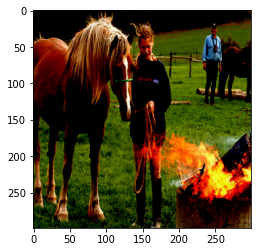

In [45]:
image_path = "/content/test_5.jpg"

img = Image.open(image_path)

img = transform(img)

plt.imshow(img.permute(1,2,0))

image_input = img.to(device=device) # check here

print(model.captionImage(image=image_input, vocabulary=dataset.vocab))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')